In [ ]:
import time
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

NUM_CLASSES = 10
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 128
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PATH = 'dataset'

def load_data(path):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST(root = path, train= True, transform= transform, download= True)
    test_dataset = datasets.MNIST(root = path, train= False, transform= transform, download= True)

    train_loader = DataLoader(dataset= train_dataset, batch_size= BATCH_SIZE, shuffle= True)
    test_loader = DataLoader(dataset= test_dataset, batch_size= BATCH_SIZE, shuffle= True)

    return train_dataset, train_loader, test_dataset, test_loader

class NeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(in_features= 784, out_features= 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=256, out_features= num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        return logits

def training(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    
    correct = 0
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(DEVICE)
        y = y.type(torch.LongTensor)
        y = y.to(DEVICE)
        y_hat = model(X)
        loss = criterion(y_hat, y)

        ## Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct_batch = (y_hat.argmax(1) == y).type(torch.float).sum().item()
        correct += correct_batch

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(dataloader.dataset)}]")

    batch_accuracy = correct / size
    batch_loss = train_loss / len(dataloader)
    return batch_loss, batch_accuracy

def testing(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    test_loss = 0

    with torch.no_grad():
        for (X, y) in dataloader:
            X = X.to(DEVICE)
            y = y.type(torch.LongTensor)
            y = y.to(DEVICE)

            y_hat = model(X)
            loss = criterion(y_hat, y)
            test_loss += loss.item()
            correct_batch = (y_hat.argmax(1) == y).type(torch.float).sum().item()
            correct += correct_batch
            
    batch_accuracy = correct / size
    batch_loss = test_loss / len(dataloader)
    return batch_loss, batch_accuracy

def visualization(train_loss, test_loss, train_accuracy, test_accuracy):
    # plt.figure(figsize= (8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='loss')
    plt.plot(test_loss, label='test_loss')
    # plt.ylim([0, 3])

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='accuracy')
    plt.plot(test_accuracy, label='val_accuracy')
    # plt.ylim([0.2, 1])

    plt.show()

def train_model(model, train_loader, test_loader, n_epochs, criterion, optimizer, ):
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []

    for epoch in range(n_epochs):
        start_time = time.time()
        print(f"Epoch {epoch+1}/{n_epochs}")
        train_epoch_loss, train_epoch_accuracy = training(dataloader= train_loader, model= model, criterion= criterion, optimizer= optimizer)
        test_epoch_loss, test_epoch_accuracy = testing(dataloader= test_loader, model= model, criterion= criterion, optimizer= optimizer)
        elapsed_time = time.time() - start_time
        
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        test_loss.append(test_epoch_loss)
        test_accuracy.append(test_epoch_accuracy)

        print("----------------------------------------")
        print(f"{len(train_loader)}/{len(train_loader)} - {int(elapsed_time)}s - loss: {train_epoch_loss} - accuracy: {train_epoch_accuracy} - val_loss: {test_epoch_loss} - val_accuracy: {test_epoch_accuracy}")
        print("==========================================================================================")
    return train_loss, test_loss, train_accuracy, test_accuracy

In [ ]:
train_dataset, train_loader, test_dataset, test_loader = load_data(path= PATH)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [ ]:
model = NeuralNetwork(NUM_CLASSES).to(DEVICE)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model.parameters(), lr= LEARNING_RATE)

train_loss, test_loss, train_accuracy, test_accuracy = train_model(train_loader= train_loader, 
                                                                   test_loader= test_loader, 
                                                                   model= model, 
                                                                   criterion= criterion, 
                                                                   optimizer= optimizer, 
                                                                   n_epochs= NUM_EPOCHS)

Epoch 1/20
loss: 2.294192  [    0/60000]
loss: 0.423835  [ 6400/60000]
loss: 0.450600  [12800/60000]
loss: 0.200842  [19200/60000]
loss: 0.212833  [25600/60000]
loss: 0.244434  [32000/60000]
loss: 0.159410  [38400/60000]
loss: 0.227736  [44800/60000]
loss: 0.168825  [51200/60000]
loss: 0.251948  [57600/60000]
----------------------------------------
469/469 - 13s - loss: 0.29912559794528143 - accuracy: 0.9107333333333333 - val_loss: 0.16240131751268724 - val_accuracy: 0.9544
Epoch 2/20
loss: 0.118963  [    0/60000]
loss: 0.197142  [ 6400/60000]
loss: 0.178753  [12800/60000]
loss: 0.130565  [19200/60000]
loss: 0.076112  [25600/60000]
loss: 0.171153  [32000/60000]
loss: 0.286821  [38400/60000]
loss: 0.077623  [44800/60000]
loss: 0.103562  [51200/60000]
loss: 0.129882  [57600/60000]
----------------------------------------
469/469 - 11s - loss: 0.13994499589842774 - accuracy: 0.95795 - val_loss: 0.12266073248620275 - val_accuracy: 0.9624
Epoch 3/20
loss: 0.071394  [    0/60000]
loss: 0.06

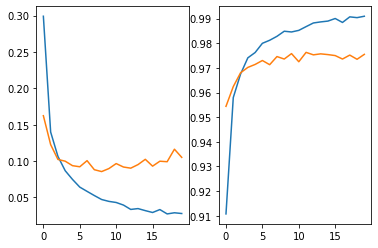

In [ ]:
visualization(train_loss, test_loss, train_accuracy, test_accuracy)